This notebook replicates the figures shown in manuscript. Sections are separated by figure number.

In [4]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
from skimage.color import label2rgb
import json
import nrrd

import pandas as pd
import seaborn as sns
# Project Root
# used for searching packages and functions
# TODO: enter your project root dir here
ROOT_DIR = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/multiTAP_public/multiTAP/'

sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution
from cytof.classes import CytofImageTiff
from cytof.classes import CytofCohort

# Figure 1 is the pipeline overview. Skipped.

# Figure 2

In [5]:
class SetParameters():
    def __init__(self, 
                 filename: str, 
                 outdir: str, 
                 label_marker_file: str, 
                 slide: Optional[str] = 'slide1', 
                 roi: Optional[str] = 'roi1', 
                 quality_control_thres: Optional[int] = 50,
                 channels_remove: Optional[List] = None, 
                 channels_dict: Optional[Dict] = None,
                 use_membrane: Optional[bool] = True,
                 cell_radius: Optional[int] = 5, 
                 normalize_qs: Optional[List[int]] = [75, 99]):
        
        self.filename = filename
        self.outdir   = outdir
        self.slide    = slide
        self.roi      = roi
        self.quality_control_thres = quality_control_thres
        self.label_marker_file     = label_marker_file
        self.channels_remove = channels_remove if channels_remove is not None else []
        self.channels_dict   = channels_dict if channels_dict is not None else {}
        self.use_membrane    = use_membrane
        self.cell_radius     = cell_radius
        self.normalize_qs    = normalize_qs


In [6]:
params = SetParameters(
    # IMC file
    filename='/archive/DPDS/Xiao_lab/shared/shidan/hyperion/The Single-Cell Pathology Landscape of Breast Cancer/OMEandSingleCellMasks/OMEnMasks/ome/ome/BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_114_115_X4Y8_262_a0_full.tiff',
    
    # Opal file
    # filename='/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/additional_opal_data/TP00899-T0-S1-1_Scan1_reg_5000_8000.tiff',
    
    outdir="../test_out/tiffs/single_roi", 
    slide="BaselTMA_SP43_25.8kx22ky",
    roi="114_115_X4Y8_262",
    # label_marker_file = "/project/DPDS/Xiao_lab/shared/lcai/Ling-Ivan/component_tiff/markers_labels_phenochart.txt",
    label_marker_file = "../example_data/markers_labels.txt",
)

In [7]:
# read slide into class object
cytof_img, _ = cytof_read_data_roi(params.filename, slide=params.slide, roi=params.roi)

# set the channels and markers
labels_markers = yaml.load(open(params.label_marker_file, "rb"), Loader=yaml.Loader)
cytof_img.set_markers(**labels_markers)

In [8]:
# remove unwanted channels (and check visualization)
channels_remove = ['nan1-nan1', 'nan2-nan2', 'nan3-nan3', 'nan4-nan4', 'nan5-nan5']
setattr(params, "channels_remove", channels_remove)

In [9]:
if hasattr(params,"channels_remove") and len(params.channels_remove) > 0:
    cytof_img.remove_special_channels(params.channels_remove)
    
    print("Original list of channels: \n{}".format(', '.join(cytof_img.raw_channels)))
    print("\nUpdated list of channels: \n{}".format(', '.join(cytof_img.channels)))


Original list of channels: 
ArgonDimers-Ar80, RutheniumTetroxide-Ru96, RutheniumTetroxide-Ru98, RutheniumTetroxide-Ru99, RutheniumTetroxide-Ru100, RutheniumTetroxide-Ru101, RutheniumTetroxide-Ru102, RutheniumTetroxide-Ru104, Histone H3-In113, nan1-nan1, nan2-nan2, Histone H3-La139, Cytokeratin 5-Pr141, Fibronectin-Nd142, Cytokeratin 19-Nd143, Cytokeratin 8or18-Nd144, Twist-Nd145, CD68-Nd146, Keratin 14 (KRT14)-Sm147, SMA-Nd148, Vimentin-Sm149, c-Myc-Nd150, c-erbB-2 - Her2-Eu151, CD3-Sm152, Histone H3-Eu153, Erk1or2-Sm154, Slug-Gd155, Rabbit IgG H L-Gd156, Progesterone Receptor AorB-Gd158, p53-Tb159, CD44-Gd160, EpCAM-Dy161, CD45-Dy162, GATA3-Dy163, CD20-Dy164, b-Catenin-Ho165, Carbonic Anhydrase IX-Er166, undefined-Er167, Ki-67-Er168, EGFR-Tm169, S6-Er170, Sox9-Yb171, vWF-CD31-Yb172, mTOR-Yb173, Cytokeratin 7-Yb174, pan Cytokeratin-Keratin Epithelial-Lu175, cleaved PARP-Cleaved Caspase3-Yb176, DNA1-Ir191, DNA2-Ir193, nan3-nan3, nan4-nan4, nan5-nan5

Updated list of channels: 
ArgonDime

## Define special channel(s)
Define nuclei channel, optionally, define membrane channel, to get prepared for nuclei and cells segmentation.  
TODO: update the class method `define_special_channels` for `CytofImageTiff`

In [10]:
#TODO: change accordingly
channel_dict = {
        'nuclei': ['DNA1-Ir191', 'DNA2-Ir193'],
        'membrane': ['Vimentin-Sm149', 'c-erbB-2 - Her2-Eu151', 'pan Cytokeratin-Keratin Epithelial-Lu175', 
                     'CD44-Gd160','Fibronectin-Nd142'], 
    }


setattr(params, 'channel_dict', channel_dict)

In [11]:
channels_ = cytof_img.channels[:]

# define special channels (if desired)
channels_rm = cytof_img.define_special_channels(params.channel_dict, rm_key='nuclei')

# remove unwanted channels (if desired)
cytof_img.remove_special_channels(channels_rm)



print("\nList of channels before defining special channel(s): \n{}".format(', '.join(channels_)))
print("\nUpdated list of channels after defining special channel(s): \n{}".format(', '.join(cytof_img.channels)))





List of channels before defining special channel(s): 
ArgonDimers-Ar80, RutheniumTetroxide-Ru96, RutheniumTetroxide-Ru98, RutheniumTetroxide-Ru99, RutheniumTetroxide-Ru100, RutheniumTetroxide-Ru101, RutheniumTetroxide-Ru102, RutheniumTetroxide-Ru104, Histone H3-In113, Histone H3-La139, Cytokeratin 5-Pr141, Fibronectin-Nd142, Cytokeratin 19-Nd143, Cytokeratin 8or18-Nd144, Twist-Nd145, CD68-Nd146, Keratin 14 (KRT14)-Sm147, SMA-Nd148, Vimentin-Sm149, c-Myc-Nd150, c-erbB-2 - Her2-Eu151, CD3-Sm152, Histone H3-Eu153, Erk1or2-Sm154, Slug-Gd155, Rabbit IgG H L-Gd156, Progesterone Receptor AorB-Gd158, p53-Tb159, CD44-Gd160, EpCAM-Dy161, CD45-Dy162, GATA3-Dy163, CD20-Dy164, b-Catenin-Ho165, Carbonic Anhydrase IX-Er166, undefined-Er167, Ki-67-Er168, EGFR-Tm169, S6-Er170, Sox9-Yb171, vWF-CD31-Yb172, mTOR-Yb173, Cytokeratin 7-Yb174, pan Cytokeratin-Keratin Epithelial-Lu175, cleaved PARP-Cleaved Caspase3-Yb176, DNA1-Ir191, DNA2-Ir193

Updated list of channels after defining special channel(s): 
Arg

In [12]:
# from cytof.classes import CytofCohort

cytof_img.defined_channels

{'membrane', 'nuclei'}

## Nuclei and cells segmentation
With the nuclei channel (and membrane channel) defined, nuclei and cells segmentation can be easily done with the class method `get_seg`.  
`cytof_img.get_seg()`

True
Nuclei segmentation...


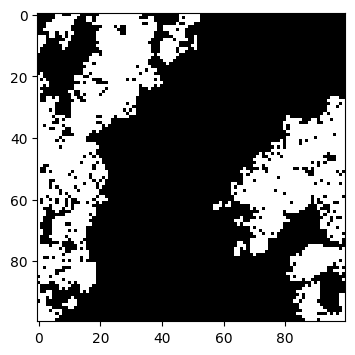

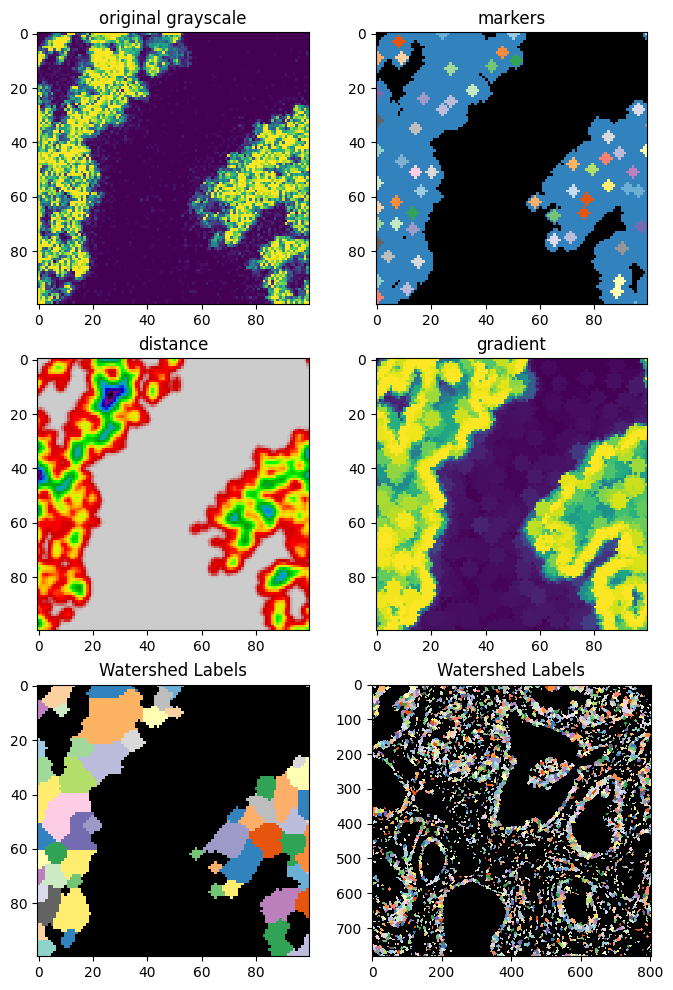

Cell segmentation...


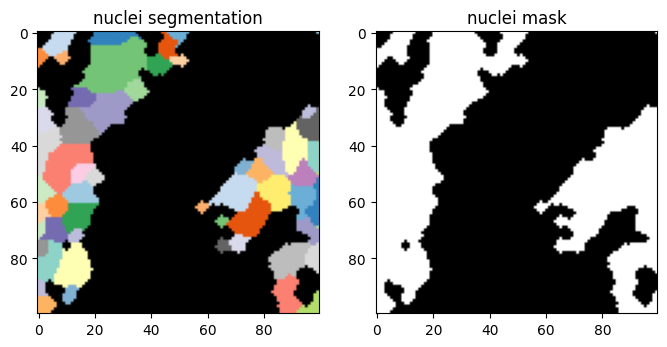

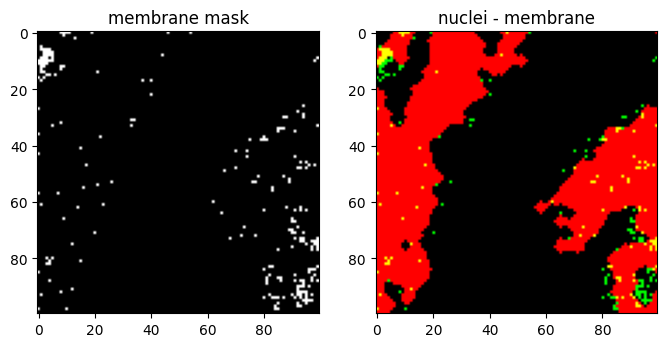

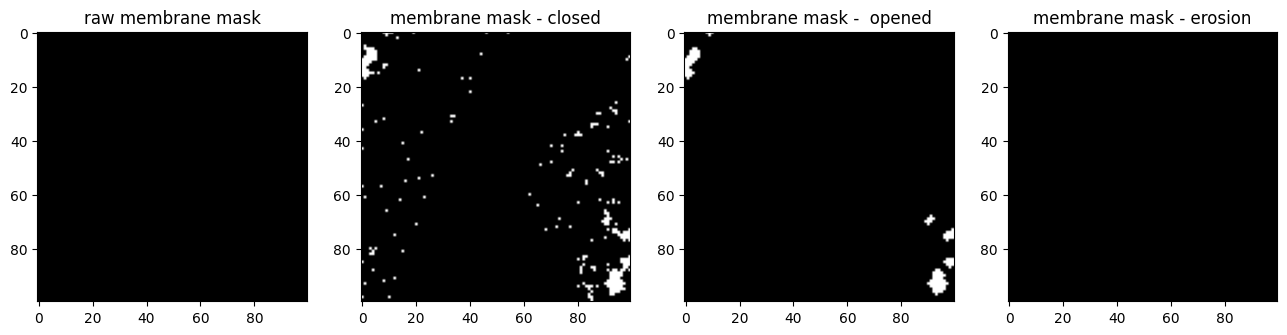

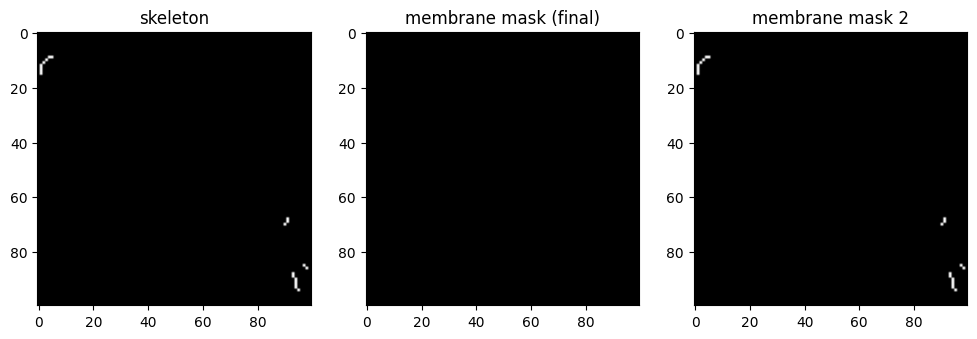

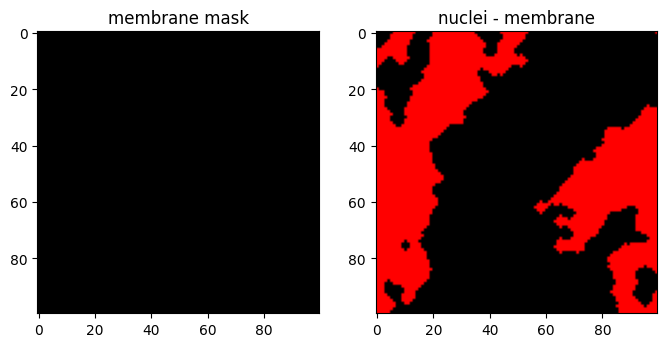

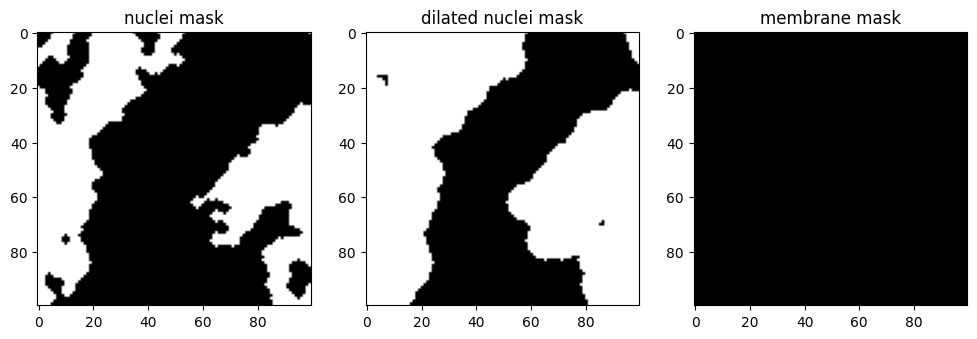

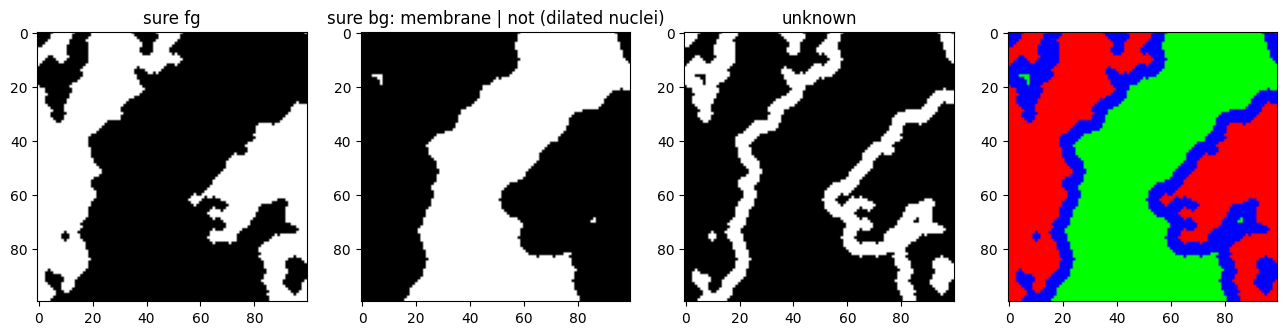

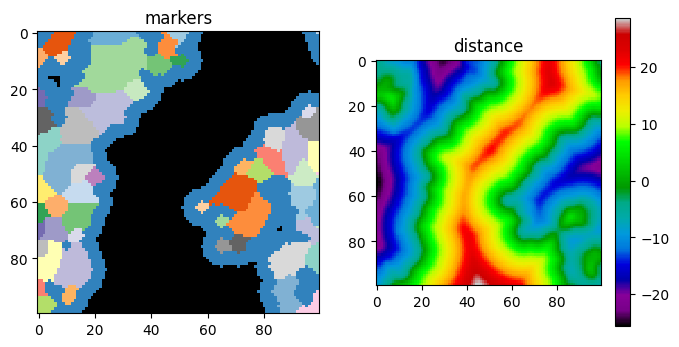

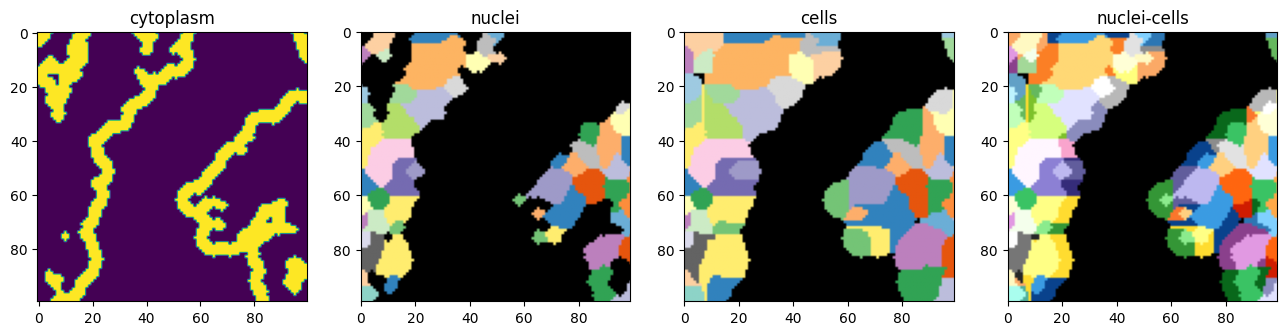

In [13]:
%matplotlib inline

print(params.use_membrane)
nuclei_seg, cell_seg = cytof_img.get_seg(use_membrane=params.use_membrane, 
                                         radius=params.cell_radius, # 10
                                         show_process=True)

## Figure 2A, 2B
Visualizations of nuclei and cells segmentation

Visualizing channels: nuclei, membrane
Visualizing... 
nuclei in red
membrane in green

Visualizing... 
nuclei in red
membrane in green

nuclei boundary marked by yellow


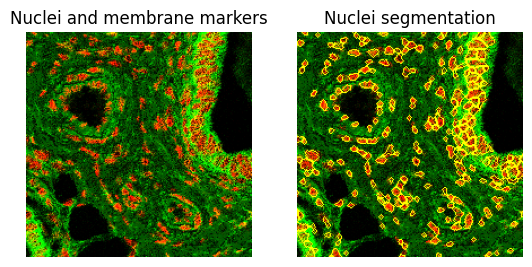

In [14]:
# choosing a subsection
vis_range = {
'h0': 300,
'h1': 500,
'w0': 200,
'w1': 400
}

#TODO: change accordingly based on membrane info
vis_channels_RGB = ['nuclei','membrane']

# visualize raw membrane and nuclei here
pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channels_RGB, visualize=False)
# visualize nuclei segmentation
marked_image_nuclei = cytof_img.visualize_seg(segtype="nuclei", show=False)

fig, ax = plt.subplots(1,2)
ax[0].imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
ax[1].imshow(marked_image_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])

ax[0].set_title('Nuclei and membrane markers')
ax[1].set_title('Nuclei segmentation')

ax[0].axis('off')
ax[1].axis('off')
plt.show()

# used for saving individual figures
# plt.imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
# plt.title('Nuclei and membrane markers')
# plt.axis('off')
# plt.savefig('figure2a.png', dpi=300)

# plt.imshow(marked_image_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
# plt.title('Nuclei segmentation')
# plt.axis('off')
# plt.savefig('figure2b.png', dpi=300)



## Figure 2C
Compare segmentation results

In [15]:
# set color map to prettify
cmap_set3 = plt.get_cmap("Set3")
cmap_tab20c = plt.get_cmap("tab20c")
colors = [cmap_tab20c.colors[_] for _ in range(len(cmap_tab20c.colors))] + \
    [cmap_set3.colors[_] for _ in range(len(cmap_set3.colors))]


In [16]:
CP_TITAN_PATH = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/image_cytof/notebooks/developer'
IMC_FOLDER = '/archive/DPDS/Xiao_lab/shared/shidan/hyperion/The Single-Cell Pathology Landscape of Breast Cancer/OMEandSingleCellMasks/OMEnMasks/ome/ome'
IMC_MASKS_FOLDER = '/archive/DPDS/Xiao_lab/shared/shidan/hyperion/The Single-Cell Pathology Landscape of Breast Cancer/OMEandSingleCellMasks/OMEnMasks/Basel_Zuri_masks/Basel_Zuri_masks'
CP_MASK_PATH = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/image_cytof/notebooks/developer/roi_masks/cellprofiler/'
TITAN_MASK_PATH = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/image_cytof/notebooks/developer/roi_masks/titan/nrrd_keep'

imc_file = 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_114_115_X4Y8_262_a0_full.tiff'

# find CellProfiler and TITAN results
# load the roi -> imc mapping file
roi_name_dict = json.load(open(os.path.join(CP_TITAN_PATH, 'roi_num_imc_name_map.json')))

roi_num = list(roi_name_dict.values()).index(imc_file)

# check the filenames match
assert roi_name_dict[f'rois/roi{roi_num}'] == imc_file

# load the CP masks result
cell_seg_cellprofiler = skimage.io.imread(os.path.join(CP_MASK_PATH, f'roi{roi_num}_cell_masks.tiff'), plugin="tifffile")

# load the TITAN masks result
cell_seg_titan, _ = nrrd.read(os.path.join(TITAN_MASK_PATH, f'roi{roi_num} Cell Mask.nrrd'))
cell_seg_titan = np.transpose(cell_seg_titan, axes=(1,0,2))[:,:,0] # TITAN processing always transposes the original images

# load ground truth
cell_seg_gt = skimage.io.imread(os.path.join(IMC_MASKS_FOLDER, imc_file.split('.tiff')[0]+"_maks.tiff"), plugin='tifffile')
  
cell_seg_pred = cell_seg - 1 # to match with gt label

# label the segmentation with better color
cell_seg_gt = label2rgb(cell_seg_gt, bg_label=0, colors=colors)
cell_seg_pred = label2rgb(cell_seg_pred, bg_label=0, colors=colors)
cell_seg_cellprofiler = label2rgb(cell_seg_cellprofiler, bg_label=0, colors=colors)
cell_seg_titan = label2rgb(cell_seg_titan, bg_label=0, colors=colors)



(-0.5, 199.5, 199.5, -0.5)

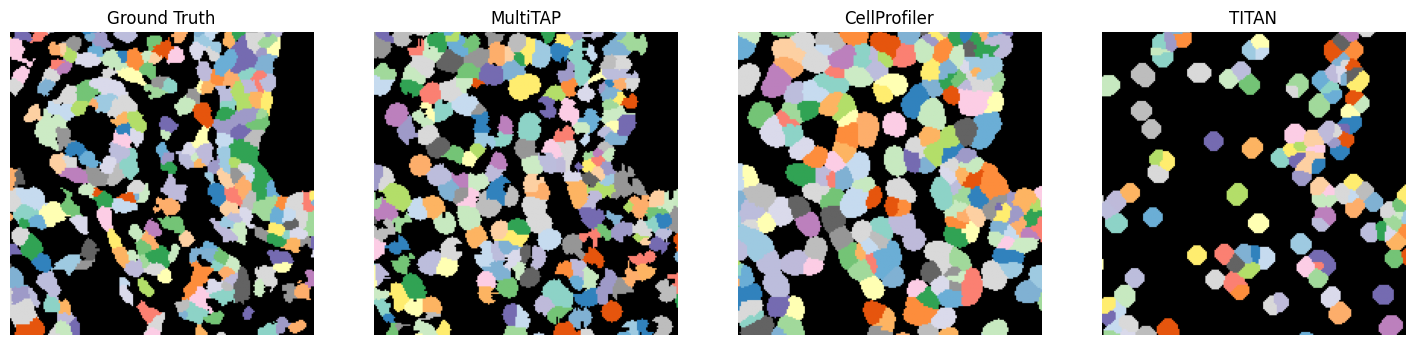

In [19]:

# visualize the results with ground truth
fig, axs = plt.subplots(1,4, figsize=(18,6))
axs[0].imshow(cell_seg_gt[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[0].set_title("Ground Truth")

axs[1].imshow(cell_seg_pred[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[1].set_title("MultiTAP")

axs[2].imshow(cell_seg_cellprofiler[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[2].set_title("CellProfiler")

axs[3].imshow(cell_seg_titan[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[3].set_title("TITAN")

# turn off axis
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

# plt.savefig('perform_comp.png', dpi=300)

## Figure 2D
To generate the `performance.json` file, please refer to `supplemental/eval_cellprofiler_titan.py`

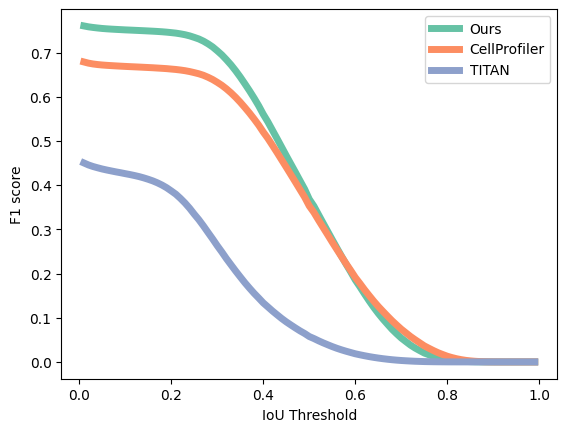

In [20]:
perform_dict = json.load(open('supplemental/final_basel_performance.json'))
perform_df = pd.DataFrame()

# threshold vs. f-score graph
perform_df['IoU Threshold'] = np.arange(0.01,1, step=0.01)
for res_key in perform_dict.keys():
    fscore_list = perform_dict[res_key][3]

    # if no matching values, they have metric_val=0
    num_zeros_to_pad = 99 - len(fscore_list)
    fscore_list = np.pad(fscore_list, pad_width=(0,num_zeros_to_pad), constant_values=0)
    perform_df[res_key] = fscore_list

# transpose the performance df for plotting
perform_df_long = pd.melt(perform_df, id_vars=['IoU Threshold'], var_name="Method", value_name="F1 score")

# make the plot
sns.lineplot(perform_df_long, x='IoU Threshold', y='F1 score', hue='Method', linewidth=5, palette=sns.color_palette("Set2", 3))    

# Get the current legend
legend = plt.legend()

# Set the linewidth of the legend lines
for line in legend.get_lines():
    line.set_linewidth(5)  # Adjust the linewidth as needed

# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.savefig('seg-fscore.png', dpi=300)
plt.show()

## Figure 2E

In [21]:
params = SetParameters(
    # IMC file
    # filename='/archive/DPDS/Xiao_lab/shared/shidan/hyperion/The Single-Cell Pathology Landscape of Breast Cancer/OMEandSingleCellMasks/OMEnMasks/ome/ome/BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_114_115_X4Y8_262_a0_full.tiff',
    
    # Opal file
    filename='/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/additional_opal_data/TP00899-T0-S1-1_Scan1_reg_x5000_y8000.tiff',
    outdir="../test_out/tiffs/single_roi", 
    slide="0",
    roi="1",
    label_marker_file = "/project/DPDS/Xiao_lab/shared/lcai/Ling-Ivan/component_tiff/markers_labels_phenochart.txt",
    # label_marker_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof_test_data/external_data/The Single-Cell Pathology Landscape of Breast Cancer/markers_labels.txt",
)

In [22]:
# read slide into class object
cytof_img_opal, _ = cytof_read_data_roi(params.filename, slide=params.slide, roi=params.roi)

# set the channels and markers
labels_markers = yaml.load(open(params.label_marker_file, "rb"), Loader=yaml.Loader)
cytof_img_opal.set_markers(**labels_markers)

print(cytof_img_opal.channels)

['DAPI-DNA', 'Opal 570-MCT1', 'Opal 480-CD8a', 'Opal 620-MCT4', 'Opal 520-CD31']


In [23]:
#TODO: change accordingly
channel_dict = {
        'nuclei': ['DAPI-DNA'],
    }

setattr(params, 'channel_dict', channel_dict)

# define special channels (if desired)
channels_rm = cytof_img_opal.define_special_channels(params.channel_dict, rm_key='nuclei')


In [24]:
#TODO: change accordingly based on membrane info
vis_channels_RGB = ['nuclei']

# visualize raw nuclei here
pseudoRGB, quantiles, color_pool = cytof_img_opal.visualize_channels(channel_names=vis_channels_RGB, visualize=False)

# No marker designed to stain membrane in this Opal batch
nuclei_seg, cell_seg = cytof_img_opal.get_seg(use_membrane=False, 
                                         radius=params.cell_radius,
                                         show_process=False)
cell_seg_pred = cell_seg - 1 # to match with gt label

# label the segmentation with better color
cell_seg_pred = label2rgb(cell_seg_pred, bg_label=0, colors=colors)
                                   

Visualizing channels: nuclei
Visualizing... 
nuclei in red



(-0.5, 999.5, 999.5, -0.5)

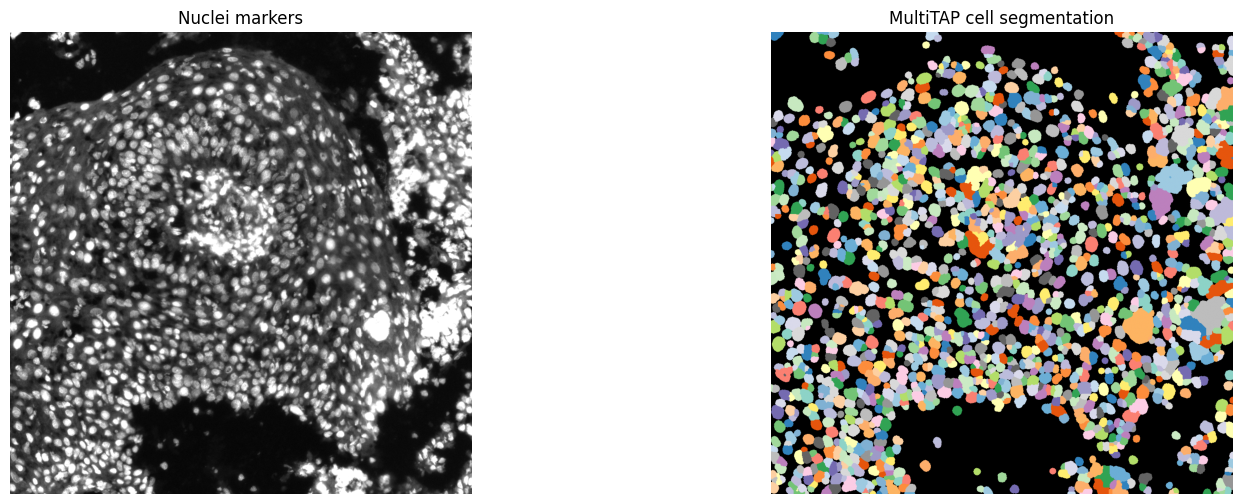

In [25]:
%matplotlib inline


# visualize the results with ground truth
fig, axs = plt.subplots(1,2, figsize=(18,6))
axs[0].imshow(pseudoRGB[:,:,0], cmap='gray')
axs[0].set_title("Nuclei markers")
axs[0].axis('off')

axs[1].imshow(cell_seg_pred)
axs[1].set_title("MultiTAP cell segmentation")
axs[1].axis('off')

# plt.savefig('figure2e.png', dpi=300)  


# Figure 3

The following step takes about 10 minutes to finish for a 150MB IMC file.

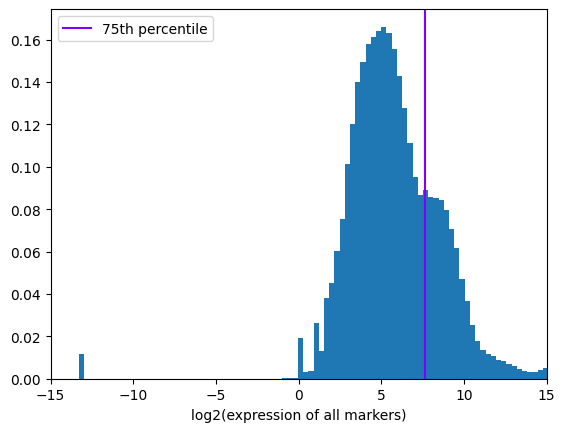

dict quantiles: {75: 201.75749969482422}


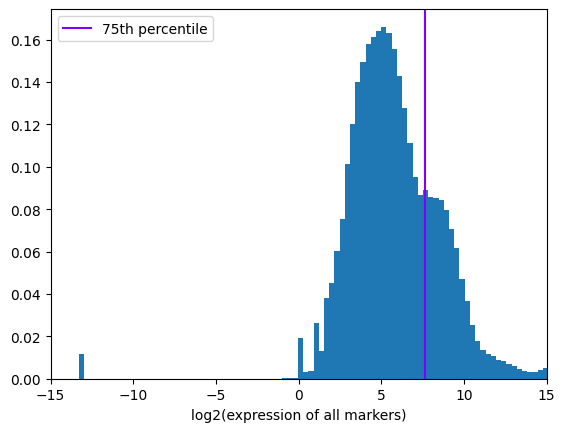

dict quantiles: {75: 201.75749969482422}
dict quantiles in batch process: {75: 201.75749969482422}


In [26]:
# extract single cell features and normalize
cytof_img.extract_features(filename=cytof_img.filename)
cytof_img.feature_quantile_normalization(qs=[75], vis_compare=False) 

# treat as a cohort (for upcoming analyses)
dict_cytof_img = {f"{cytof_img.slide}_{cytof_img.roi}": cytof_img}
cytof_img.calculate_quantiles(qs=[75])
cytof_cohort = CytofCohort(cytof_images=dict_cytof_img)
cytof_cohort.batch_process_feature()

In [27]:
# runs marker positive summary for all images in the cohort
cytof_cohort.generate_summary()


Getting thresholds for cell sum of all markers.


['75normed_sum']

In [28]:
vis_marker = "Fibronectin-Nd142" 
vis_channel = "Fibronectin-Nd142"
stain_nuclei, stain_cell, color_dict = cytof_img.visualize_marker_positive(
                                        marker=vis_marker,
                                        feature_type="normed",
                                        accumul_type="sum",
                                        normq=75,
                                        show_boundary=True,
                                        color_list=[(0,0,1), (0,1,0)], # negative, positive
                                        color_bound=(0,0,0),
                                        show_colortable=False)

vis_channel_names = [vis_channel, "nuclei"]
pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channel_names, 
                              visualize=False)

Visualizing channels: Fibronectin-Nd142, nuclei
Visualizing... 
Fibronectin-Nd142 in red
nuclei in green



## Figure 3A, C

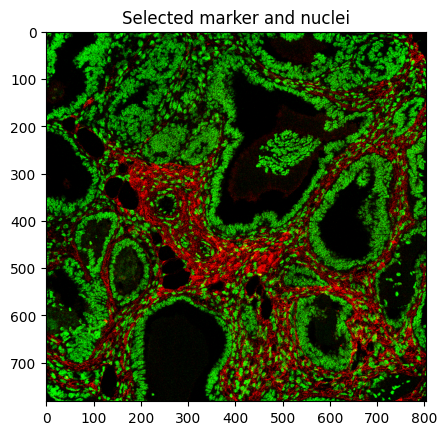

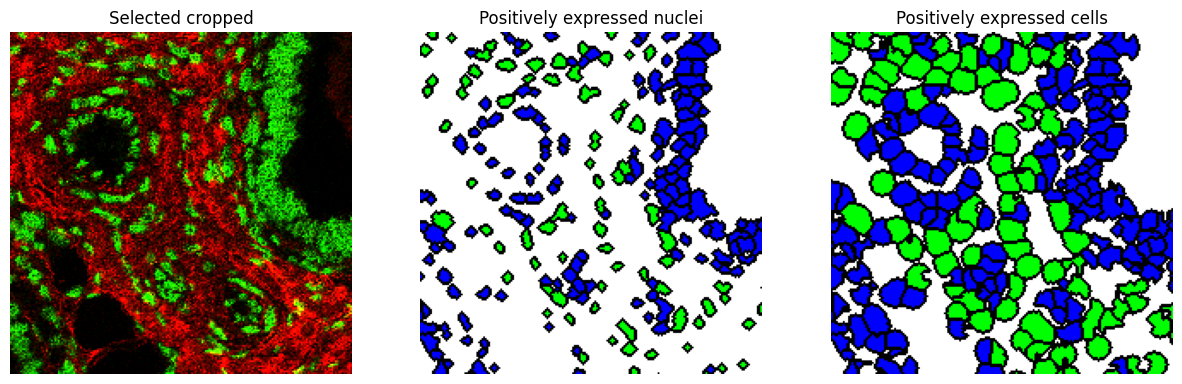

In [29]:
%matplotlib inline

r, c, _ = pseudoRGB.shape
maxr = min(r, 300)
maxc = min(c, 300)

plt.imshow(pseudoRGB)
plt.title('Selected marker and nuclei')
# plt.savefig('figure3a.png', dpi=300)
plt.show()

fig, axs = plt.subplots(1,3,figsize=(15, 5))
axs[0].imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])

axs[0].set_title('Selected cropped')
axs[0].axis('off')
axs[1].imshow(stain_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[1].set_title('Positively expressed nuclei')
axs[1].axis('off')
axs[2].imshow(stain_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[2].set_title('Positively expressed cells')
axs[2].axis('off')
# plt.savefig('figure3c.png', dpi=300)
plt.show()



## Figure 3b

In [30]:
from sklearn.mixture import GaussianMixture
import scipy

In [31]:
# modified from utils._get_thresholds
# used specifically for visualizing a marker
def _get_thresholds(df_feature: pd.DataFrame,
                    features: List[str],
                    thres_bg: float = 0.3,
                    visualize: bool = True,
                    verbose: bool = False,
                    viz_title: str = ''):
    """Calculate thresholds for each feature by assuming a Gaussian Mixture Model
    Inputs:
        df_feature = dataframe of extracted feature summary
        features   = a list of features to calculate thresholds from
        thres_bg   = a threshold such that the component with the mixing weight greater than the threshold would
                            be considered as background. (Default=0.3)
        visualize  = a flag indicating whether to visualize the feature distributions and thresholds or not.
                            (Default=True)
        verbose    = a flag indicating whether to print calculated values on screen or not. (Default=False)
    Outputs:
        thresholds = a dictionary of calculated threshold values
    :param df_feature: pandas.core.frame.DataFrame
    :param features: list
    :param visualize: bool
    :param verbose: bool
    :return thresholds: dict
    """
    thresholds = {}
    for f, feat_name in enumerate(features):
        X = df_feature[feat_name].values.reshape(-1, 1)
        gm = GaussianMixture(n_components=2, random_state=0, n_init=2).fit(X)
        mu = np.min(gm.means_[gm.weights_ > thres_bg])
        which_component = np.argmax(gm.means_ == mu)

        if verbose:
            print(f"GMM mean values: {gm.means_}")
            print(f"GMM weights: {gm.weights_}")
            print(f"GMM covariances: {gm.covariances_}")

        X     = df_feature[feat_name].values
        hist  = np.histogram(X, 150)
        sigma = np.sqrt(gm.covariances_[which_component, 0, 0])
        background_ratio = gm.weights_[which_component]
        thres = sigma * 2.5 + mu
        thresholds[feat_name] = thres

        n = sum(X > thres)
        percentage = n / len(X)

        ## visualize
        if visualize:
            fig, ax = plt.subplots(1, 1)
            ax.hist(X, 150, density=True)
            ax.set_xlabel("log2({})".format(viz_title))
            ax.plot(hist[1], scipy.stats.norm.pdf(hist[1], mu, sigma) * background_ratio, c='red')

            _which_component = np.argmin(gm.means_ == mu)
            _mu = gm.means_[_which_component]
            _sigma = np.sqrt(gm.covariances_[_which_component, 0, 0])
            ax.plot(hist[1], scipy.stats.norm.pdf(hist[1], _mu, _sigma) * (1 - background_ratio), c='orange')

            ax.axvline(x=thres, c='red')
            ax.text(0.7, 0.9, "n={}, percentage={}".format(n, np.round(percentage, 3)), ha='center', va='center',
                    transform=ax.transAxes)
            ax.text(0.3, 0.9, "mu={}, sigma={}".format(np.round(mu, 2), np.round(sigma, 2)), ha='center', va='center',
                    transform=ax.transAxes)
            ax.text(0.3, 0.8, "background ratio={}".format(np.round(background_ratio, 2)), ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title(viz_title)
            # plt.savefig('figure3b.png', dpi=300)
            plt.show()
    return thresholds

In [32]:
# generates the marker summaries based on normq
cytof_cohort.generate_summary(feat_type="normed_scaled", normq=75, verbose=True, vis_thres=False)

# extracts the df_feature
df_feature_name = 'df_feature_75normed_scaled'
df_feat = getattr(cytof_cohort, df_feature_name)

Getting thresholds for cell sum of all markers.
GMM mean values: [[-0.81472361]
 [ 0.5472213 ]]
GMM weights: [0.40179372 0.59820628]
GMM covariances: [[[0.71943091]]

 [[0.44271133]]]
GMM mean values: [[-0.78900204]
 [ 0.52086529]]
GMM weights: [0.39764737 0.60235263]
GMM covariances: [[[0.70956882]]

 [[0.50901681]]]
GMM mean values: [[-0.71022401]
 [ 0.45781469]]
GMM weights: [0.39195178 0.60804822]
GMM covariances: [[[0.91820821]]

 [[0.51753309]]]
GMM mean values: [[-0.76127748]
 [ 0.50503787]]
GMM weights: [0.39882467 0.60117533]
GMM covariances: [[[0.74358066]]

 [[0.53012349]]]
GMM mean values: [[-0.77668041]
 [ 0.52172653]]
GMM weights: [0.40182048 0.59817952]
GMM covariances: [[[0.71021253]]

 [[0.51679615]]]
GMM mean values: [[-0.75222018]
 [ 0.51815094]]
GMM weights: [0.4078736 0.5921264]
GMM covariances: [[[0.72671805]]

 [[0.52954381]]]
GMM mean values: [[-0.76857758]
 [ 0.5057407 ]]
GMM weights: [0.39687151 0.60312849]
GMM covariances: [[[0.73126659]]

 [[0.53190932]]]
GM

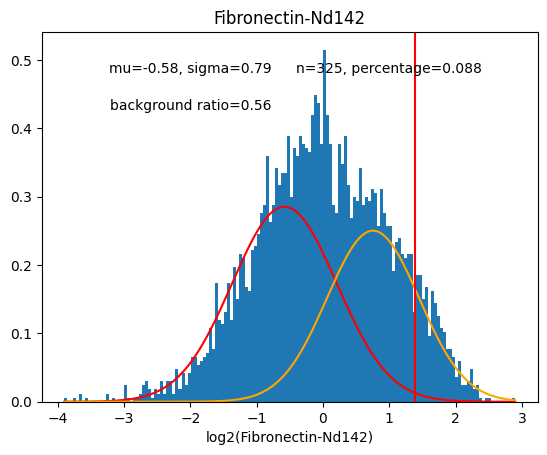

{'Fibronectin-Nd142_cell_sum': 1.3916772567906182}

In [33]:
pos_viz_marker_name = 'Fibronectin-Nd142'
viz_feature = f'{pos_viz_marker_name}_cell_sum'
_get_thresholds(df_feat, features=[viz_feature], viz_title=pos_viz_marker_name)

# Figure 4
Generate ROI and slide level interaction analysis.

Cohort was processed externally. Too large to be computed by IPython kernels. See `CLIscripts/batch_feature_extract.sh`

In [34]:
from cytof.classes import CytofCohort
one_slide = 'BaselTMA_SP43_25'
one_roi = '114_115_X4Y8_262'


## Figure 4A

### loading the img from pkl file
pkl file generated from `CLIscripts.batch_process_feature.py`

In [35]:
whole_slide_pkl_path = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/image_cytof/CLIscripts/SlideBaselTMA_SP43_25_final.pkl'
cytof_cohort_whole_slide = pkl.load(open(whole_slide_pkl_path, 'rb'))

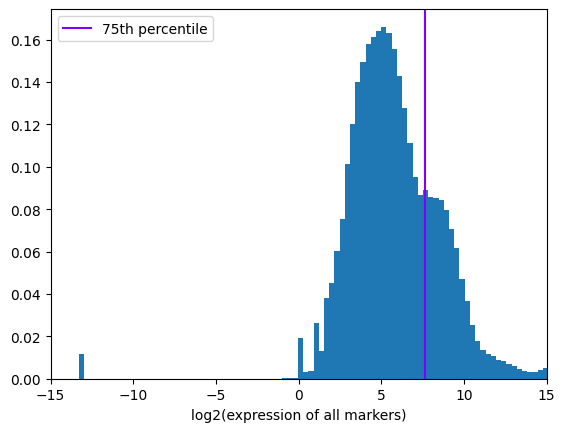

dict quantiles: {75: 201.75749969482422}
dict quantiles in batch process: {75: 201.75749969482422}
Getting thresholds for cell sum of all markers.


['75normed_sum']

In [36]:
# get the feature df (marker1, marker2, ... vs. cell1, cell2)
accumul_type = 'sum'
cytof_img_ind_test = cytof_cohort_whole_slide[f'{one_slide}_{one_roi}']
df_feature_name = 'df_feature_75normed'
df_feat = getattr(cytof_img_ind_test, df_feature_name)
marker_col_all = [x for x in df_feat.columns if f"cell_{accumul_type}" in x]
df_cell_sum = df_feat[marker_col_all]

# get the marker threshold (marker1, markers, ... vs. positive counts, thresholds)
cytof_img_ind_test.calculate_quantiles(qs=[75])

# still need to process features through a batch
# more likely, the cohort will contain multiple ROIs. Then user will batch process and generate feature summary
# after summaries are attached to individual ROIs, eahc cytof_img can be called with co-expression-analysis
cytof_cohort_of_one = CytofCohort(cytof_images={f'test_slide_roi':cytof_img_ind_test})
cytof_cohort_of_one.batch_process_feature()
cytof_cohort_of_one.generate_summary()

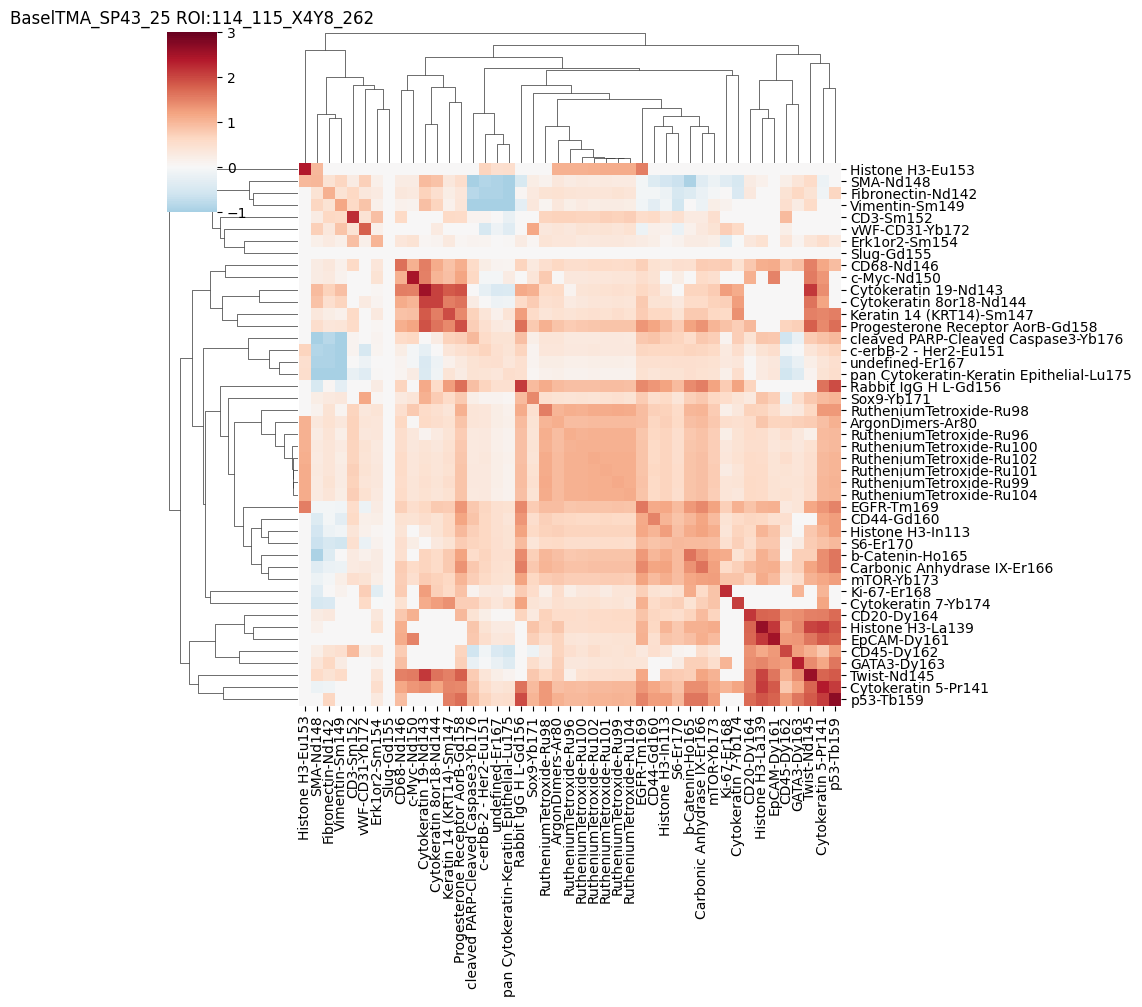

In [37]:
# calling the individual ROI co-expression-analysis
df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

epsilon = 1e-6 # avoid divide by 0 or log(0)

# Normalize and fix Nan
edge_percentage_norm = np.log10(df_co_pos_prob.values / (df_expected_prob.values+epsilon) + epsilon)

# if observed/expected = 0, then log odds ratio will have log10(epsilon)
# no observed means co-expression cannot be determined, does not mean strong negative co-expression
edge_percentage_norm[edge_percentage_norm == np.log10(epsilon)] = 0

# do some post processing
marker_all_clean = [m.replace('_cell_sum', '') for m in df_expected_prob.columns]


# fig = plt.figure()
clustergrid = sns.clustermap(edge_percentage_norm,
                # clustergrid = sns.clustermap(edge_percentage_norm,
                center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                xticklabels=marker_all_clean, yticklabels=marker_all_clean)

plt.title(f'{one_slide} ROI:{one_roi}')
# plt.savefig('figure4a.pdf', format='pdf', dpi=300, bbox_inches='tight') # tight to save all edges of the figure
plt.show()

## Figure 4B
Co-expression analysis at the slide level. Because the large number of ROIs in each slide, Jupyter Notebooks did not allow sufficient OPENBLAS threads. Please reference `CLIscripts/cohort_coexpression.py` on how to generate figure 4b.

## Figure 5
Spatial interactions

In [38]:
# df_expected_prob, df_cell_interaction_prob = cytof_img_ind_test.roi_interaction_graphs(feature_name='75normed', accumul_type='sum', method='distance', threshold=50)
df_expected_prob, df_cell_interaction_prob = cytof_img_ind_test.roi_interaction_graphs(feature_name='75normed', accumul_type='sum', method='k-neighbor', threshold=30)

# do some post processing
marker_all = df_expected_prob.columns
epsilon = 1e-6

# Normalize and fix Nan
edge_percentage_norm = np.log10(df_cell_interaction_prob.values / (df_expected_prob.values+epsilon) + epsilon)

# if observed/expected = 0, then log odds ratio will have log10(epsilon)
# no observed means interaction cannot be determined, does not mean strong negative interaction
edge_percentage_norm[edge_percentage_norm == np.log10(epsilon)] = 0


Calculating spatial interaction with method "k-neighbor" and threshold at 30


In [39]:
marker_all_clean = [m.replace('_cell_sum', '') for m in marker_all]
marker_all_clean

['ArgonDimers-Ar80',
 'RutheniumTetroxide-Ru96',
 'RutheniumTetroxide-Ru98',
 'RutheniumTetroxide-Ru99',
 'RutheniumTetroxide-Ru100',
 'RutheniumTetroxide-Ru101',
 'RutheniumTetroxide-Ru102',
 'RutheniumTetroxide-Ru104',
 'Histone H3-In113',
 'Histone H3-La139',
 'Cytokeratin 5-Pr141',
 'Fibronectin-Nd142',
 'Cytokeratin 19-Nd143',
 'Cytokeratin 8or18-Nd144',
 'Twist-Nd145',
 'CD68-Nd146',
 'Keratin 14 (KRT14)-Sm147',
 'SMA-Nd148',
 'Vimentin-Sm149',
 'c-Myc-Nd150',
 'c-erbB-2 - Her2-Eu151',
 'CD3-Sm152',
 'Histone H3-Eu153',
 'Erk1or2-Sm154',
 'Slug-Gd155',
 'Rabbit IgG H L-Gd156',
 'Progesterone Receptor AorB-Gd158',
 'p53-Tb159',
 'CD44-Gd160',
 'EpCAM-Dy161',
 'CD45-Dy162',
 'GATA3-Dy163',
 'CD20-Dy164',
 'b-Catenin-Ho165',
 'Carbonic Anhydrase IX-Er166',
 'undefined-Er167',
 'Ki-67-Er168',
 'EGFR-Tm169',
 'S6-Er170',
 'Sox9-Yb171',
 'vWF-CD31-Yb172',
 'mTOR-Yb173',
 'Cytokeratin 7-Yb174',
 'pan Cytokeratin-Keratin Epithelial-Lu175',
 'cleaved PARP-Cleaved Caspase3-Yb176']

In [40]:
print(np.min(edge_percentage_norm))
print(np.max(edge_percentage_norm))

-1.5037858286863408
1.5114871920435797


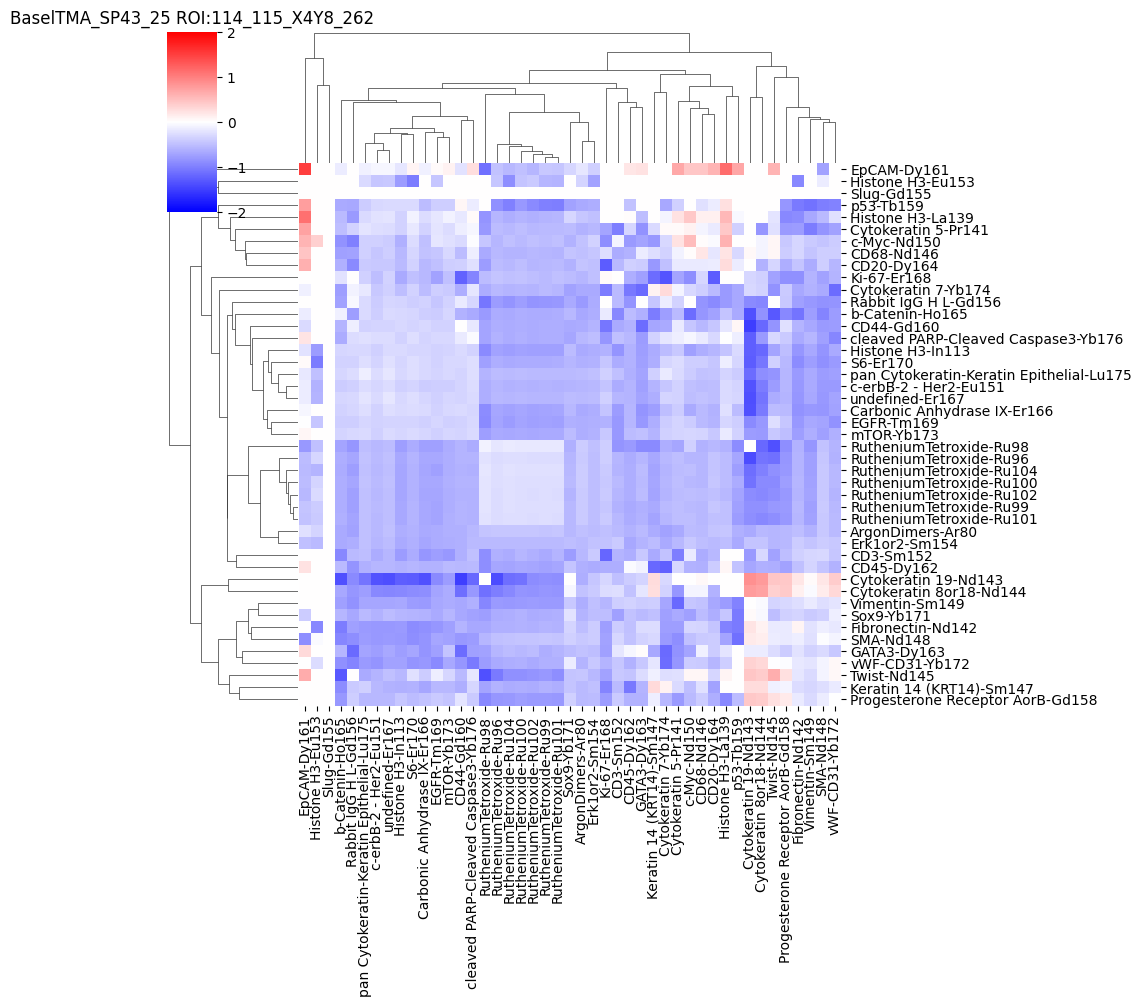

In [41]:
# visualize the coexpression plot
%matplotlib inline
clustergrid = sns.clustermap(edge_percentage_norm,
                            # clustergrid = sns.clustermap(edge_percentage_norm,
                            center=np.log10(1 + epsilon), cmap='bwr', vmin=-2, vmax=2,
                            xticklabels=marker_all_clean, yticklabels=marker_all_clean)

plt.title(f'{one_slide} ROI:{one_roi}')

# plt.savefig('figure5a.pdf', format='pdf', dpi=300, bbox_inches='tight') # tight to save all edges of the figure
plt.show()

### Marker visualization check

In [42]:
def visualize_marker(cytof_img, channel1, channel2):
  """
  Visualizes marker given the marker and channel name. This is visualizaed along with the nuclei channel

  """
  vis_channel_names = [channel1, "nuclei"]
  pseudoRGB1, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channel_names, 
                              visualize=False)

  vis_channel_names = [channel2, "nuclei"]
  pseudoRGB2, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channel_names, 
                              visualize=False)

  fig, axs = plt.subplots(1,2,figsize=(15, 5))

  axs[0].imshow(pseudoRGB1), axs[0].set_title(channel1)
  axs[1].imshow(pseudoRGB2), axs[1].set_title(channel2)
  plt.show()

  

In [43]:
def viz_pos_marker_pair(cytof_img, marker1, marker2, vis_range, set_title=True):
  
  stain_nuclei1, stain_cell1, color_dict = cytof_img.visualize_marker_positive(
                                        marker=marker1,
                                        feature_type="normed",
                                        accumul_type="sum",
                                        normq=75,
                                        show_boundary=True,
                                        color_list=[(0,0,1), (0,1,0)], # negative, positive
                                        color_bound=(0,0,0),
                                        show_colortable=False)

  stain_nuclei2, stain_cell2, color_dict = cytof_img.visualize_marker_positive(
                                        marker=marker2,
                                        feature_type="normed",
                                        accumul_type="sum",
                                        normq=75,
                                        show_boundary=True,
                                        color_list=[(0,0,1), (0,1,0)], # negative, positive
                                        color_bound=(0,0,0),
                                        show_colortable=False)
  fig, axs = plt.subplots(1,2)

  axs[0].imshow(stain_cell1[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
  axs[1].imshow(stain_cell2[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
  
  if set_title: # not for saving subplots
    axs[0].set_title(f'positive {marker1} cells')
    axs[1].set_title(f'positive {marker2} cells')
    plt.tight_layout()
  else: # don't apply tight layout
    axs[0].axis('off')
    axs[1].axis('off')


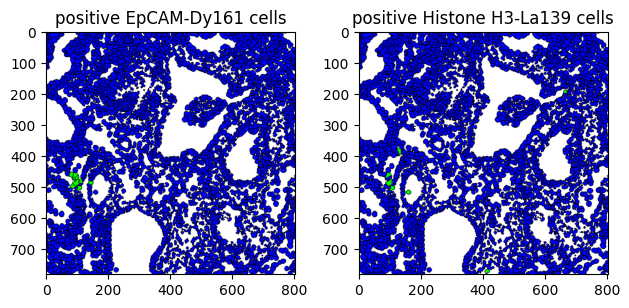

In [44]:
%matplotlib inline
vis_range = {
'h0': 000,
'h1': 800,
'w0': 000,
'w1': 900
}


viz_pos_marker_pair(cytof_img, 'EpCAM-Dy161', 'Histone H3-La139', vis_range)
# plt.savefig('figure5b.pdf', format='pdf', dpi=300)

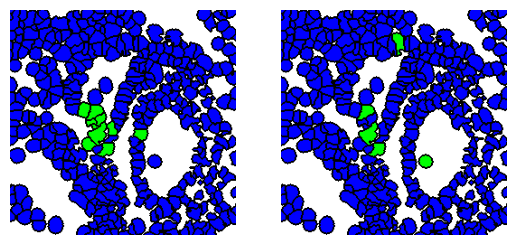

In [45]:
%matplotlib inline
vis_range = {
'h0': 350,
'h1': 600,
'w0': 0,
'w1': 250
}


viz_pos_marker_pair(cytof_img, 'EpCAM-Dy161', 'Histone H3-La139', vis_range, set_title=False)
# plt.axis('off')

# plt.savefig('figure5b-1.pdf', format='pdf', dpi=300)

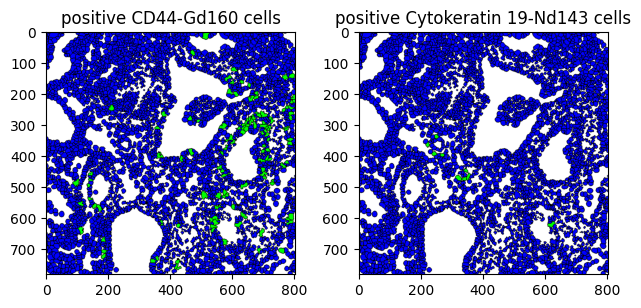

In [46]:
%matplotlib inline 
vis_range = {
  'h0': 000,
  'h1': 800,
  'w0': 000,
  'w1': 900
  }

viz_pos_marker_pair(cytof_img, 'CD44-Gd160', 'Cytokeratin 19-Nd143', vis_range)
# plt.savefig('figure5c.pdf', format='pdf', dpi=300)

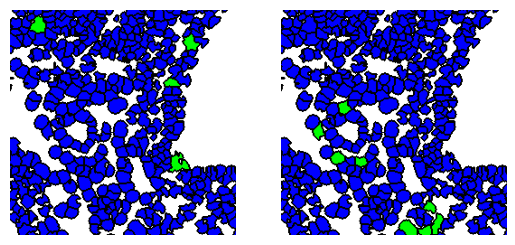

In [47]:
%matplotlib inline 
vis_range = {
  'h0': 230,
  'h1': 480,
  'w0': 180,
  'w1': 430
  }

viz_pos_marker_pair(cytof_img, 'CD44-Gd160', 'Cytokeratin 19-Nd143', vis_range, set_title=False)
# plt.savefig('figure5c-1.pdf', format='pdf', dpi=300)

# Figure 6

In [48]:
import random
from cytof.utils import show_color_table

## Figure 6A

In [49]:
# intentially break phenograph
key_pheno = cytof_cohort.clustering_phenograph()




The attribute name of the feature: df_feature_75normed_scaled
Finding 36 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5991406440734863 seconds
Jaccard graph constructed in 2.123561143875122 seconds
Wrote graph to binary file in 0.0846402645111084 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.692697
After 5 runs, maximum modularity is Q = 0.696728
Louvain completed 25 runs in 2.557094097137451 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.108125925064087 seconds

9 communities found. The dictionary key for phenograph: 75normed_scaled_all_feature_36_all_markers.


Visualization in 2d - cohort-cohort


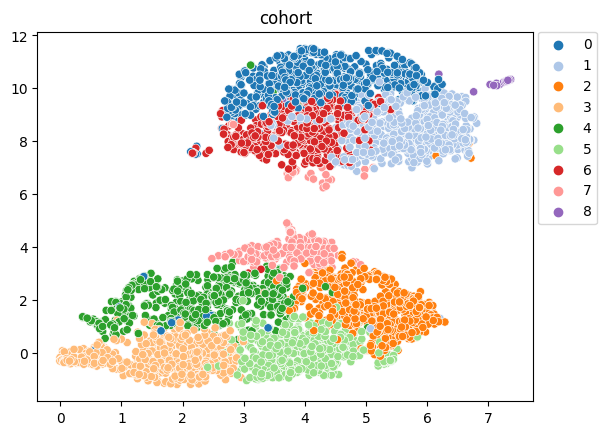

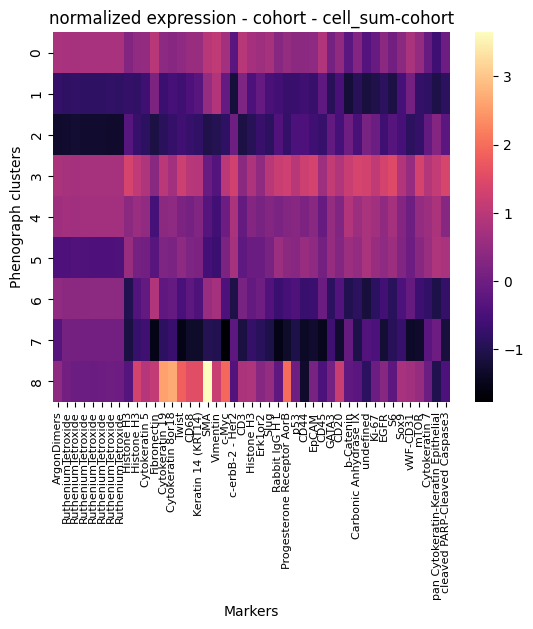

<Figure size 640x480 with 0 Axes>

In [50]:
## visualize
df_feats, commus, cluster_protein_exps, figs, figs_scatter, figs_exps = cytof_cohort.vis_phenograph(
    key_pheno=key_pheno,
    level="cohort",
    save_vis=False, # change here to save
    show_plots=True,
    plot_together=False)

# plt.savefig('figure5a.png', dpi=300)

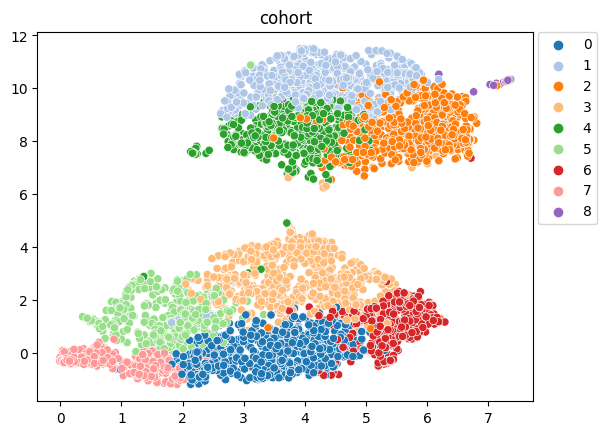

In [49]:
# %matplotlib inline
ax = figs_scatter['cohort']
ax

In [50]:
# ax.figure.savefig('figure6a.pdf', format='pdf', dpi=300)

## Figure 6B

In [51]:
# vis_multi, quantiles, color_pool = \
# cytof_img.visualize_channels(channel_names=["nuclei", random.choice(cytof_img.channels)],#, "CD38(Pr141Di)"], 
#     visualize=False)

vis_multi, quantiles, color_pool = cytof_img.visualize_channels(channel_names=["nuclei", 'Fibronectin-Nd142'],#, "CD38(Pr141Di)"], 
    visualize=False)   

# attch PhenoGraph results to individual ROIs
cytof_cohort.attach_individual_roi_pheno(key_pheno, override=True)

# PhenoGraph clustering visualization
pheno_stain_nuclei, pheno_stain_cell, color_dict = cytof_img.visualize_pheno(key_pheno=key_pheno)




Visualizing channels: nuclei, Fibronectin-Nd142
Visualizing... 
nuclei in red
Fibronectin-Nd142 in green



In [52]:
vis_range = {
'h0': 300,
'h1': 500,
'w0': 200,
'w1': 400
}

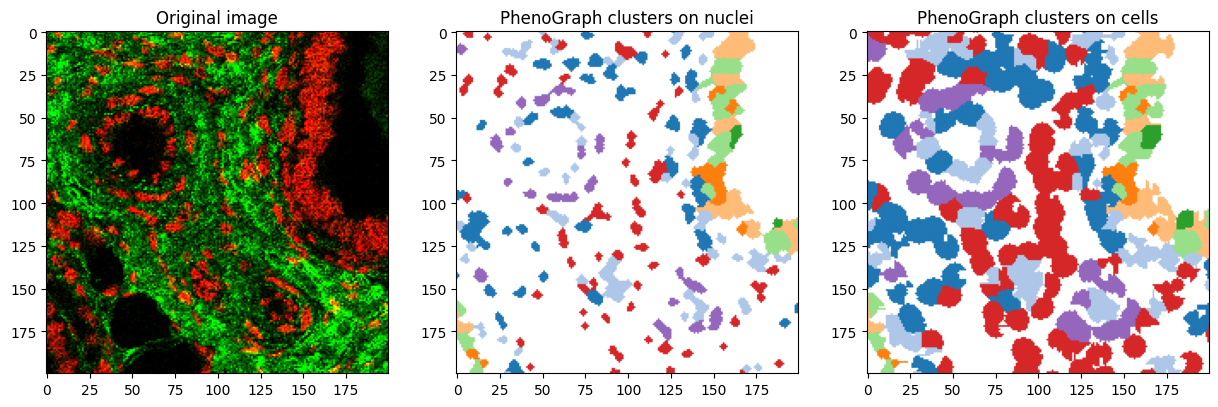

(-0.5, 199.5, 199.5, -0.5)

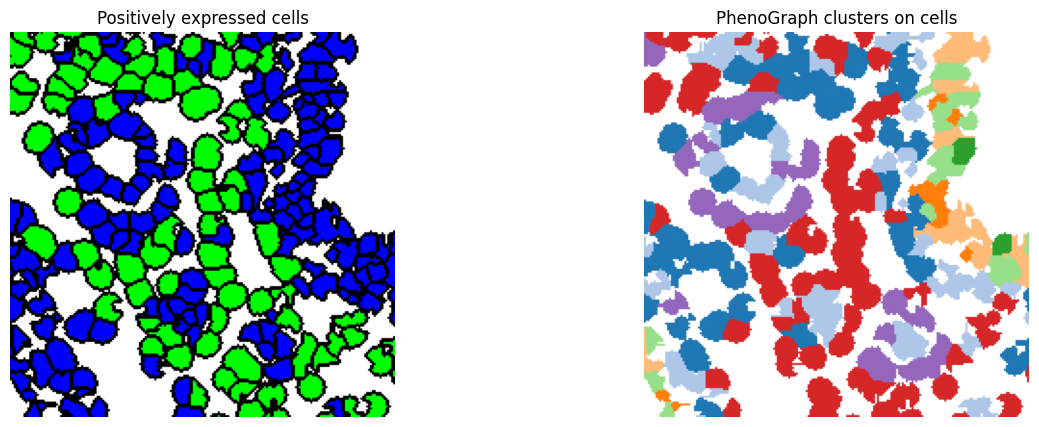

In [53]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(vis_multi[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
axs[1].imshow(pheno_stain_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
axs[2].imshow(pheno_stain_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
axs[0].set_title("Original image")
axs[1].set_title("PhenoGraph clusters on nuclei")
axs[2].set_title("PhenoGraph clusters on cells")

plt.show()

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].imshow(stain_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1']])
axs[0].set_title('Positively expressed cells')
axs[0].axis('off')

axs[1].imshow(pheno_stain_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
axs[1].set_title("PhenoGraph clusters on cells")
axs[1].axis('off')

# plt.savefig('figure5b.png', dpi=300)

## Figure 6C

thres: 50


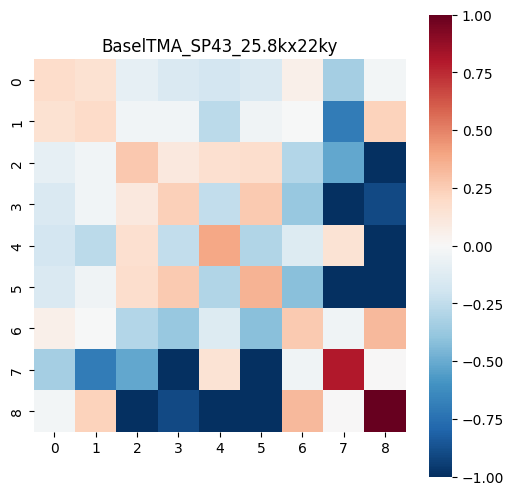

<Figure size 640x480 with 0 Axes>

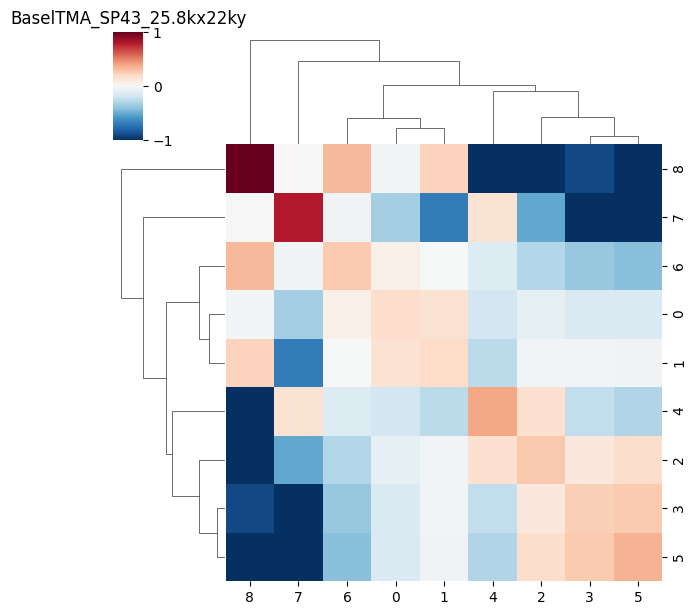

<Figure size 640x480 with 0 Axes>

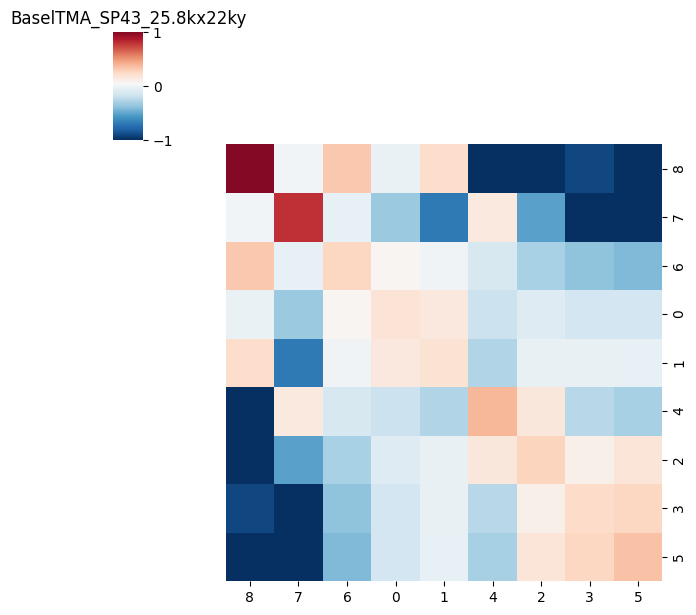

In [54]:
interacts, clustergrid = cytof_cohort.cluster_interaction_analysis(key_pheno)

In [55]:
print(interacts.keys())
interact = interacts['BaselTMA_SP43_25.8kx22ky']

dict_keys(['BaselTMA_SP43_25.8kx22ky'])


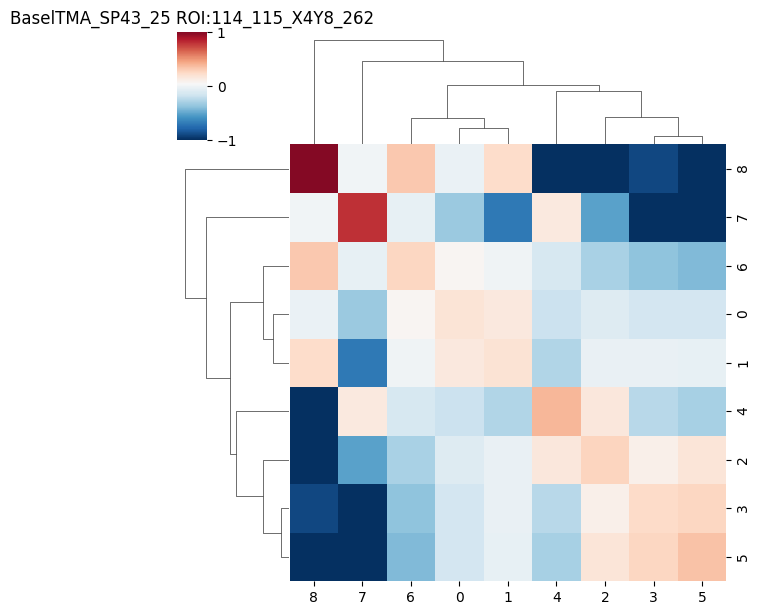

In [56]:
clustergrid_interaction = sns.clustermap(interact, center=np.log10(1 + 0.1),
                              cmap='RdBu_r', vmin=-1, vmax=1,
                              xticklabels=np.arange(interact.shape[0]),
                              yticklabels=np.arange(interact.shape[0]),
                              figsize=(6, 6))

plt.title('BaselTMA_SP43_25 ROI:114_115_X4Y8_262')
# plt.savefig('figure6c.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()